# Applying all filters at training time on FLAIR data

Building a sequence of artifact transforms for cross-modality.



## Setup imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)
from monai.utils import set_determinism

import torch
from torch.utils.data import random_split
from tqdm import tqdm
import pickle

############################################
# Local imports

SOURCE_CODE_PATH = '/homes/yc7620/Documents/medical-vision-textural-bias/source_code/'
import sys
sys.path.append(SOURCE_CODE_PATH)

from filters_and_operators import (ConvertToMultiChannelBasedOnBratsClassesd,
                                   SelectChanneld,
                                   RandFourierDiskMaskd,
                                   SaltAndPepper,
                                   RandPlaneWaves_ellipsoid,
                                  WrapArtifactd)

from utils import show_slice_and_fourier, ReCompose, BratsValIterDataset, model_evaluation
#############################################

# set determinism for reproducibility
set_determinism(seed=0)


root_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/'
print('root_dir', root_dir)
print_config()

device = torch.device("cuda:0")

root_dir /vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/
MONAI version: 0.5.dev2113
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: b3cc668c924b2a7e6b822416f4d920a098c27704

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.1.2
Tensorboard version: 2.5.0
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup transforms for each dataset

In [2]:
val_transform_baseline_FLAIR = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        SelectChanneld(["image", "label"], (0, 1))
    ]
)

val_transform_baseline_T2 = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        SelectChanneld(["image", "label"], (3, 1))
    ]
)


## Load data with DecathlonDataset

In [3]:
# baseline FLAIR
val_ds_baseline_FLAIR = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_baseline_FLAIR,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_baseline_FLAIR = random_split(val_ds_baseline_FLAIR, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_baseline_FLAIR = DataLoader(test_ds_baseline_FLAIR, batch_size=2, shuffle=False, num_workers=4)


# baseline T2
val_ds_baseline_T2 = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform_baseline_T2,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=50
)

_ , test_ds_baseline_T2 = random_split(val_ds_baseline_T2, [48, 48],
                                   torch.Generator().manual_seed(0))
test_loader_baseline_T2 = DataLoader(test_ds_baseline_T2, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


In [6]:
val_ds_baseline_T2[0]['image_meta_dict']

{'sizeof_hdr': array(348, dtype=int32),
 'extents': array(0, dtype=int32),
 'session_error': array(0, dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  4, 240, 240, 155,   4,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(16, dtype=int16),
 'bitpix': array(32, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([1., 1., 1., 1., 1., 0., 0., 0.], dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(10, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'slice_duration': array(0., dtype=float32),
 'toffset': array(0., dtype=float32),
 'glmax': array(0, dtype=int32),
 'glmin': ar

## Check data shape and visualize

Samples are images of shape torch.Size([1, 128, 128, 64]).
Labels are segmentation labels of shape torch.Size([1, 128, 128, 64]).


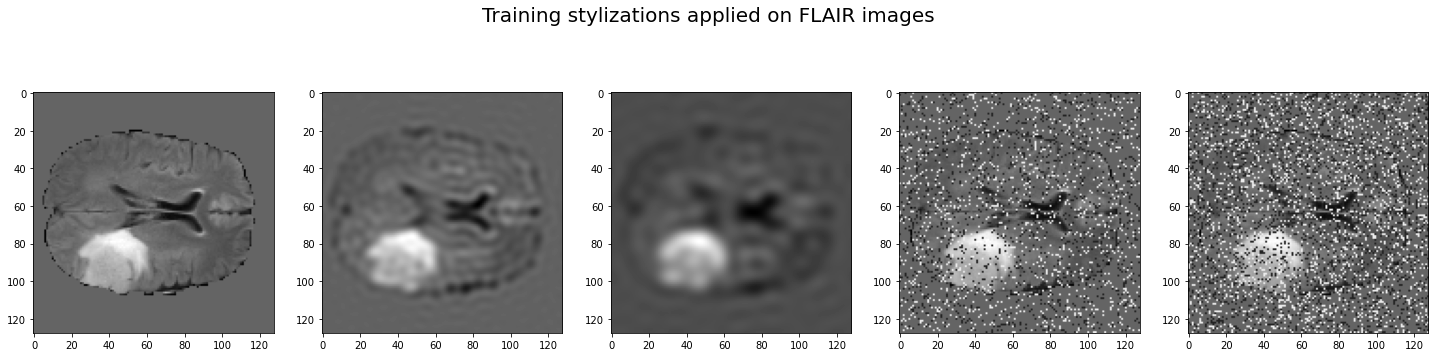

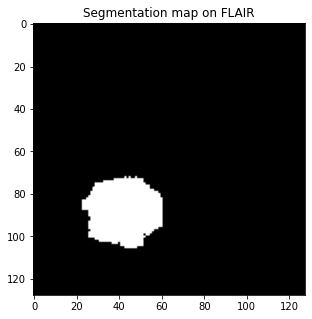

In [8]:
# FLAIR data
sample_images = [test_ds_baseline_FLAIR[20]['image'],
                test_ds_gibbs20_FLAIR[20]['image'],
                test_ds_gibbs12p5_FLAIR[20]['image'],
                test_ds_sap0p15_FLAIR[20]['image'],
                test_ds_sap0p25_FLAIR[20]['image'],]

label = test_ds_baseline_FLAIR[20]['label']

print(f"Samples are images of shape {sample_images[0].size()}.")
print(f"Labels are segmentation labels of shape {label.size()}.")


plt.figure(figsize=(25,6))
plt.suptitle('Training stylizations applied on FLAIR images', size=20)
for i in range(len(sample_images)):
    plt.subplot(1,len(sample_images),i+1)
    plt.imshow(sample_images[i][0, :, :, 32].detach().cpu(), cmap="gray")
plt.show()
    

# visualize label
plt.figure("label", (5, 5))
plt.title("Segmentation map on FLAIR")
plt.imshow(label[0, :, :, 32].detach().cpu(), cmap="gray")
plt.show()

Test images have shape: torch.Size([1, 128, 128, 64]).
Test segmentation maps have shape: torch.Size([1, 128, 128, 64]).


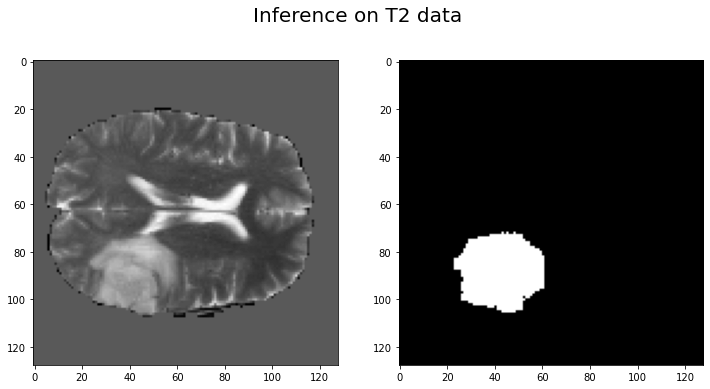

In [26]:
# T2 data for inference
sample_image_T2 = test_ds_baseline_T2[20]
                   

# label_T2 = test_ds_baseline_T2[20]['label']

print(f"Test images have shape: {sample_image_T2['image'].size()}.")
print(f"Test segmentation maps have shape: {sample_image_T2['label'].size()}.")

plt.figure(figsize=(12,6))
plt.suptitle("Inference on T2 data", size=20)

plt.subplot(1,2,1)
plt.imshow(sample_image_T2["image"][0,:,:,32], cmap="gray")
plt.subplot(1,2,2)
plt.imshow(sample_image_T2["label"][0,:,:,32], cmap="gray")
plt.show()

# Learning curves

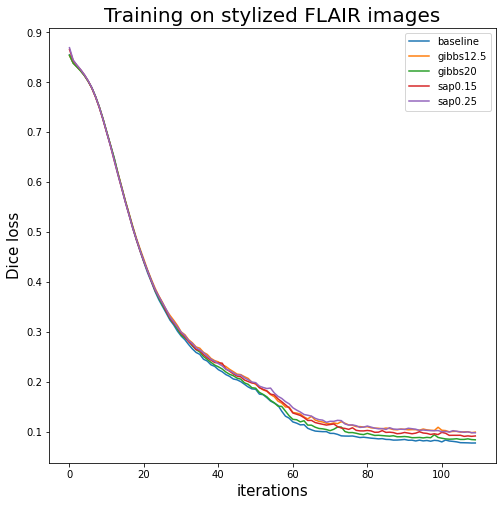

In [5]:
# learning curves 

epoch_loss_baseline_FLAIR = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_FLAIRmod_WT/epoch_loss_values_baseline_model_FLAIRmod_WT.txt')

epoch_loss_gibbs12p5_FLAIR = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_FLAIRmod_WT/epoch_loss_values_stylized_model_gibbs12.5_FLAIRmod_WT.txt')

epoch_loss_gibbs20_FLAIR = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs20_FLAIRmod_WT/epoch_loss_values_stylized_model_gibbs20_FLAIRmod_WT.txt')

epoch_loss_sap0p15_FLAIR = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_sap0.15_FLAIRmod_WT/epoch_loss_values_stylized_model_sap0.15_FLAIRmod_WT.txt')

epoch_loss_sap0p25_FLAIR = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_sap0.25_FLAIRmod_WT/epoch_loss_values_stylized_model_sap0.25_FLAIRmod_WT.txt')

plt.figure(figsize=(8,8))
plt.plot(range(len(epoch_loss_baseline_FLAIR)), epoch_loss_baseline_FLAIR, label='baseline')
# plt.hlines([.075, .19, .1],0,180, colors='k')
plt.plot(range(len(epoch_loss_baseline_FLAIR)), epoch_loss_gibbs12p5_FLAIR, label='gibbs12.5')
plt.plot(range(len(epoch_loss_baseline_FLAIR)), epoch_loss_gibbs20_FLAIR, label='gibbs20')
plt.plot(range(len(epoch_loss_baseline_FLAIR)), epoch_loss_sap0p15_FLAIR, label='sap0.15')
plt.plot(range(len(epoch_loss_baseline_FLAIR)), epoch_loss_sap0p25_FLAIR, label='sap0.25')
plt.legend()
plt.title('Training on stylized FLAIR images', size=20)
plt.xlabel('iterations', size = 15)
plt.ylabel('Dice loss', size = 15)
plt.show()

# Inference

### Cross-modality model comparisons

In [4]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_FLAIRmod_WT/baseline_model_FLAIRmod_WT.pth'
baseline_eval = model_evaluation(path, 'baseline model', in_channels=1, out_channels=1)
baseline_eval.add_eval('baseline_data', test_loader_baseline_FLAIR)
baseline_eval.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_FLAIRmod_WT/stylized_model_gibbs12.5_FLAIRmod_WT.pth'
gibbs12p5 = model_evaluation(path, 'gibbs12.5', in_channels=1, out_channels=1)
gibbs12p5.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs20_FLAIRmod_WT/stylized_model_gibbs20_FLAIRmod_WT.pth'
gibbs20 = model_evaluation(path, 'gibbs20', in_channels=1, out_channels=1)
gibbs20.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs20.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_sap0.15_FLAIRmod_WT/stylized_model_sap0.15_FLAIRmod_WT.pth'
sap15 = model_evaluation(path, 'sap0.15', in_channels=1, out_channels=1)
sap15.add_eval('baseline_data', test_loader_baseline_FLAIR)
sap15.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_sap0.25_FLAIRmod_WT/stylized_model_sap0.25_FLAIRmod_WT.pth'
sap25 = model_evaluation(path, 'sap0.25', in_channels=1, out_channels=1)
sap25.add_eval('baseline_data', test_loader_baseline_FLAIR)
sap25.add_eval('T2', test_loader_baseline_T2)

100%|██████████| 24/24 [00:24<00:00,  1.04s/it]


In [23]:
for d in [baseline_eval, gibbs12p5, gibbs20, sap15, sap25]:
    print(f" FLAIR-FLAIR {d.instance_name} Dice = {d.eval_dict['baseline_data'] : .2f}")
print("~~")
for d in [baseline_eval, gibbs12p5, gibbs20, sap15, sap25]:
    print(f" FLAIR-T2 {d.instance_name} Dice = {d.eval_dict['T2'] : .2f}")

 FLAIR-FLAIR baseline model Dice =  0.88
 FLAIR-FLAIR gibbs12.5 Dice =  0.86
 FLAIR-FLAIR gibbs20 Dice =  0.86
 FLAIR-FLAIR sap0.15 Dice =  0.86
 FLAIR-FLAIR sap0.25 Dice =  0.84
~~
 FLAIR-T2 baseline model Dice =  0.53
 FLAIR-T2 gibbs12.5 Dice =  0.48
 FLAIR-T2 gibbs20 Dice =  0.43
 FLAIR-T2 sap0.15 Dice =  0.51
 FLAIR-T2 sap0.25 Dice =  0.49


## Sample predictions

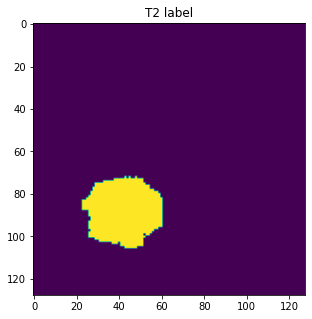

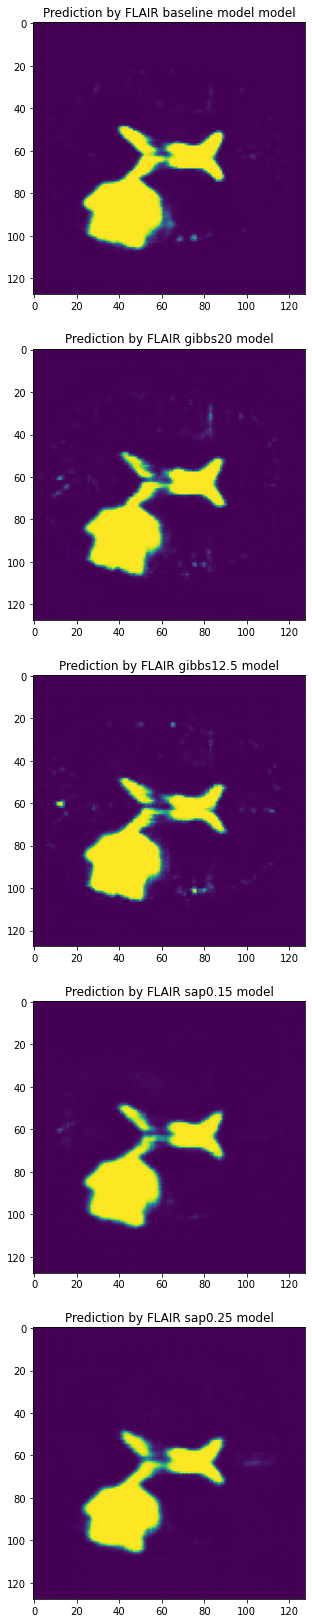

In [27]:
baseline_eval.model.eval()
with torch.no_grad():
    plt.figure("truth",(5,5))
    plt.imshow(sample_image_T2["label"][0,:,:,32])
    plt.title("T2 label")
    plt.show()
    plt.figure("pred", (100,29))
    for i, e in enumerate([baseline_eval, gibbs20, gibbs12p5, sap15, sap25]):
        model = e.model.to(device)
        model.eval()
        val_input = sample_image_T2["image"].unsqueeze(0).to(device)
        out = model(val_input).detach().cpu()
        plt.subplot(5,1,i+1)
        plt.imshow(torch.sigmoid(out[0,0,:,:,32]))
        plt.title(f"Prediction by FLAIR {e.instance_name} model")
    plt.show()

# Sequential artifacts

1. Scan performance under a type of artifact.
2. Select best stylization intensity from the above results.
3. Apply selected artifact intensity. Scan intensities of next artifact.
4. ...

## Gibbs scan

In [4]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs25_FLAIRmod_WT/stylized_model_gibbs25_FLAIRmod_WT.pth'
gibbs25 = model_evaluation(path, 'gibbs25', in_channels=1, out_channels=1)
gibbs25.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs25.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs20_FLAIRmod_WT/stylized_model_gibbs20_FLAIRmod_WT.pth'
gibbs20 = model_evaluation(path, 'gibbs20', in_channels=1, out_channels=1)
gibbs20.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs20.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs15_FLAIRmod_WT/stylized_model_gibbs15_FLAIRmod_WT.pth'
gibbs15 = model_evaluation(path, 'gibbs15', in_channels=1, out_channels=1)
gibbs15.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs15.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_FLAIRmod_WT/stylized_model_gibbs12.5_FLAIRmod_WT.pth'
gibbs12p5 = model_evaluation(path, 'gibbs12.5', in_channels=1, out_channels=1)
gibbs12p5.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs9_FLAIRmod_WT/stylized_model_gibbs9_FLAIRmod_WT.pth'
gibbs9 = model_evaluation(path, 'gibbs9', in_channels=1, out_channels=1)
gibbs9.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs9.add_eval('T2', test_loader_baseline_T2)

100%|██████████| 24/24 [00:20<00:00,  1.15it/s]


In [6]:
for d in [gibbs25, gibbs20, gibbs15, gibbs12p5, gibbs9]:
    print(f" FLAIR-FLAIR {d.instance_name} Dice = {d.eval_dict['baseline_data'] : .2f}")
print("~~")
for d in [gibbs25, gibbs20, gibbs15, gibbs12p5, gibbs9]:
    print(f" FLAIR-T2 {d.instance_name} Dice = {d.eval_dict['T2'] : .2f}")

 FLAIR-FLAIR gibbs25 Dice =  0.86
 FLAIR-FLAIR gibbs20 Dice =  0.86
 FLAIR-FLAIR gibbs15 Dice =  0.86
 FLAIR-FLAIR gibbs12.5 Dice =  0.86
 FLAIR-FLAIR gibbs9 Dice =  0.85
~~
 FLAIR-T2 gibbs25 Dice =  0.45
 FLAIR-T2 gibbs20 Dice =  0.43
 FLAIR-T2 gibbs15 Dice =  0.42
 FLAIR-T2 gibbs12.5 Dice =  0.48
 FLAIR-T2 gibbs9 Dice =  0.48


## Gibbs 12.5 fixed. Scan spikes

In [5]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes17.0_FLAIRmod_WT/stylized_model_gibbs12.5_spikes17.0_FLAIRmod_WT.pth'
gibbs12p5_spikes17 = model_evaluation(path, 'gibbs12p5_spikes17', in_channels=1, out_channels=1)
gibbs12p5_spikes17.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes17.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes16.0_FLAIRmod_WT/stylized_model_gibbs12.5_spikes16.0_FLAIRmod_WT.pth'
gibbs12p5_spikes16 = model_evaluation(path, 'gibbs12p5_spikes16', in_channels=1, out_channels=1)
gibbs12p5_spikes16.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes16.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_FLAIRmod_WT/stylized_model_gibbs12.5_spikes15.0_FLAIRmod_WT.pth'
gibbs12p5_spikes15 = model_evaluation(path, 'gibbs12p5_spikes15', in_channels=1, out_channels=1)
gibbs12p5_spikes15.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes15.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes14.0_FLAIRmod_WT/stylized_model_gibbs12.5_spikes14.0_FLAIRmod_WT.pth'
gibbs12p5_spikes14 = model_evaluation(path, 'gibbs12p5_spikes14', in_channels=1, out_channels=1)
gibbs12p5_spikes14.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes14.add_eval('T2', test_loader_baseline_T2)

# path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes13.0_FLAIRmod_WT/stylized_model_gibbs12.5_spikes13.0_FLAIRmod_WT.pth'
# gibbs12p5_spikes13 = model_evaluation(path, 'gibbs12p5_spikes13', in_channels=1, out_channels=1)
# gibbs12p5_spikes13.add_eval('baseline_data', test_loader_baseline_FLAIR)
# gibbs12p5_spikes13.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes12.0_FLAIRmod_WT/stylized_model_gibbs12.5_spikes12.0_FLAIRmod_WT.pth'
gibbs12p5_spikes12 = model_evaluation(path, 'gibbs12p5_spikes12', in_channels=1, out_channels=1)
gibbs12p5_spikes12.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes12.add_eval('T2', test_loader_baseline_T2)

100%|██████████| 24/24 [00:21<00:00,  1.10it/s]


In [6]:
for d in [gibbs12p5_spikes12, gibbs12p5_spikes14, gibbs12p5_spikes15, gibbs12p5_spikes16, gibbs12p5_spikes17]:
    print(f" FLAIR-FLAIR {d.instance_name} Dice = {d.eval_dict['baseline_data'] : .2f}")
print("~~")
for d in [gibbs12p5_spikes12, gibbs12p5_spikes14, gibbs12p5_spikes15, gibbs12p5_spikes16, gibbs12p5_spikes17]:
    print(f" FLAIR-T2 {d.instance_name} Dice = {d.eval_dict['T2'] : .2f}")

 FLAIR-FLAIR gibbs12p5_spikes12 Dice =  0.87
 FLAIR-FLAIR gibbs12p5_spikes14 Dice =  0.85
 FLAIR-FLAIR gibbs12p5_spikes15 Dice =  0.84
 FLAIR-FLAIR gibbs12p5_spikes16 Dice =  0.71
 FLAIR-FLAIR gibbs12p5_spikes17 Dice =  0.55
~~
 FLAIR-T2 gibbs12p5_spikes12 Dice =  0.47
 FLAIR-T2 gibbs12p5_spikes14 Dice =  0.50
 FLAIR-T2 gibbs12p5_spikes15 Dice =  0.53
 FLAIR-T2 gibbs12p5_spikes16 Dice =  0.48
 FLAIR-T2 gibbs12p5_spikes17 Dice =  0.45


## Gibbs 12.5, spikes 15 fixed. Scan wraparound.

In [4]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.0_FLAIRmod_WT/stylized_model_gibbs12.5_spikes15.0_wrap0.0_FLAIRmod_WT.pth'
gibbs12p5_spikes15_wrap0 = model_evaluation(path, 'gibbs12.5_spikes15_wrap0', in_channels=1, out_channels=1)
gibbs12p5_spikes15_wrap0.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes15_wrap0.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.25_FLAIRmod_WT/stylized_model_gibbs12.5_spikes15.0_wrap0.25_FLAIRmod_WT.pth'
gibbs12p5_spikes15_wrap0p25 = model_evaluation(path, 'gibbs12.5_spikes15_wrap0.25', in_channels=1, out_channels=1)
gibbs12p5_spikes15_wrap0p25.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes15_wrap0p25.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.5_FLAIRmod_WT/stylized_model_gibbs12.5_spikes15.0_wrap0.5_FLAIRmod_WT.pth'
gibbs12p5_spikes15_wrap0p5 = model_evaluation(path, 'gibbs12.5_spikes15_wrap0.5', in_channels=1, out_channels=1)
gibbs12p5_spikes15_wrap0p5.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes15_wrap0p5.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.75_FLAIRmod_WT/stylized_model_gibbs12.5_spikes15.0_wrap0.75_FLAIRmod_WT.pth'
gibbs12p5_spikes15_wrap0p75 = model_evaluation(path, 'gibbs12.5_spikes15_wrap0.75', in_channels=1, out_channels=1)
gibbs12p5_spikes15_wrap0p75.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes15_wrap0p75.add_eval('T2', test_loader_baseline_T2)

100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


In [5]:
for d in [gibbs12p5_spikes15_wrap0, gibbs12p5_spikes15_wrap0p25, gibbs12p5_spikes15_wrap0p5, gibbs12p5_spikes15_wrap0p75]:
    print(f" FLAIR-FLAIR {d.instance_name} Dice = {d.eval_dict['baseline_data'] : .2f}")
print("~~")
for d in [gibbs12p5_spikes15_wrap0, gibbs12p5_spikes15_wrap0p25, gibbs12p5_spikes15_wrap0p5, gibbs12p5_spikes15_wrap0p75]:
    print(f" FLAIR-T2 {d.instance_name} Dice = {d.eval_dict['T2'] : .2f}")

 FLAIR-FLAIR gibbs12.5_spikes15_wrap0 Dice =  0.55
 FLAIR-FLAIR gibbs12.5_spikes15_wrap0.25 Dice =  0.63
 FLAIR-FLAIR gibbs12.5_spikes15_wrap0.5 Dice =  0.78
 FLAIR-FLAIR gibbs12.5_spikes15_wrap0.75 Dice =  0.84
~~
 FLAIR-T2 gibbs12.5_spikes15_wrap0 Dice =  0.43
 FLAIR-T2 gibbs12.5_spikes15_wrap0.25 Dice =  0.52
 FLAIR-T2 gibbs12.5_spikes15_wrap0.5 Dice =  0.53
 FLAIR-T2 gibbs12.5_spikes15_wrap0.75 Dice =  0.52


## Gibbs 12.5, spikes 15, wraparound 0.5 fixed. Scan salt-and-pepper

In [4]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.05_FLAIRmod_WT/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.05_FLAIRmod_WT.pth'
gibbs12p5_spikes15_wrap0p5_sap0p05 = model_evaluation(path, 'gibbs12.5_spikes15_wrap0.5_sap0.05', in_channels=1, out_channels=1)
gibbs12p5_spikes15_wrap0p5_sap0p05.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes15_wrap0p5_sap0p05.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.15_FLAIRmod_WT/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.15_FLAIRmod_WT.pth'
gibbs12p5_spikes15_wrap0p5_sap0p15 = model_evaluation(path, 'gibbs12.5_spikes15_wrap0.5_sap0.15', in_channels=1, out_channels=1)
gibbs12p5_spikes15_wrap0p5_sap0p15.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes15_wrap0p5_sap0p15.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.25_FLAIRmod_WT/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.25_FLAIRmod_WT.pth'
gibbs12p5_spikes15_wrap0p5_sap0p25 = model_evaluation(path, 'gibbs12.5_spikes15_wrap0.5_sap0.25', in_channels=1, out_channels=1)
gibbs12p5_spikes15_wrap0p5_sap0p25.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes15_wrap0p5_sap0p25.add_eval('T2', test_loader_baseline_T2)

path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.35_FLAIRmod_WT/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.35_FLAIRmod_WT.pth'
gibbs12p5_spikes15_wrap0p5_sap0p35 = model_evaluation(path, 'gibbs12.5_spikes15_wrap0.5_sap0.35', in_channels=1, out_channels=1)
gibbs12p5_spikes15_wrap0p5_sap0p35.add_eval('baseline_data', test_loader_baseline_FLAIR)
gibbs12p5_spikes15_wrap0p5_sap0p35.add_eval('T2', test_loader_baseline_T2)

100%|██████████| 24/24 [00:15<00:00,  1.51it/s]


In [5]:
for d in [gibbs12p5_spikes15_wrap0p5_sap0p05, gibbs12p5_spikes15_wrap0p5_sap0p15, gibbs12p5_spikes15_wrap0p5_sap0p25, gibbs12p5_spikes15_wrap0p5_sap0p35]:
    print(f" FLAIR-FLAIR {d.instance_name} Dice = {d.eval_dict['baseline_data'] : .2f}")
print("~~")
for d in [gibbs12p5_spikes15_wrap0p5_sap0p05, gibbs12p5_spikes15_wrap0p5_sap0p15, gibbs12p5_spikes15_wrap0p5_sap0p25, gibbs12p5_spikes15_wrap0p5_sap0p35]:
    print(f" FLAIR-T2 {d.instance_name} Dice = {d.eval_dict['T2'] : .2f}")

 FLAIR-FLAIR gibbs12.5_spikes15_wrap0.5_sap0.05 Dice =  0.75
 FLAIR-FLAIR gibbs12.5_spikes15_wrap0.5_sap0.15 Dice =  0.71
 FLAIR-FLAIR gibbs12.5_spikes15_wrap0.5_sap0.25 Dice =  0.68
 FLAIR-FLAIR gibbs12.5_spikes15_wrap0.5_sap0.35 Dice =  0.58
~~
 FLAIR-T2 gibbs12.5_spikes15_wrap0.5_sap0.05 Dice =  0.51
 FLAIR-T2 gibbs12.5_spikes15_wrap0.5_sap0.15 Dice =  0.49
 FLAIR-T2 gibbs12.5_spikes15_wrap0.5_sap0.25 Dice =  0.50
 FLAIR-T2 gibbs12.5_spikes15_wrap0.5_sap0.35 Dice =  0.46


### Learning curves for selected models

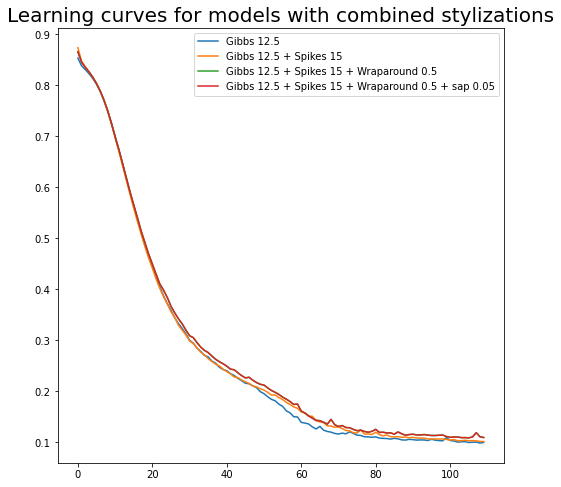

In [6]:
gibbs_loss = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_FLAIRmod_WT/epoch_loss_values_stylized_model_gibbs12.5_FLAIRmod_WT.txt')

gibbs_spikes_loss = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_FLAIRmod_WT/epoch_loss_values_stylized_model_gibbs12.5_spikes15.0_FLAIRmod_WT.txt')
    
gibbs_spikes_wrap_loss = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.5_FLAIRmod_WT/epoch_loss_values_stylized_model_gibbs12.5_spikes15.0_wrap0.5_FLAIRmod_WT.txt')

gibbs_spikes_wrap_sap_loss = np.loadtxt('/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.05_FLAIRmod_WT/epoch_loss_values_stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.05_FLAIRmod_WT.txt')

plt.figure(figsize=(8,8))
plt.plot(range(len(gibbs_loss)), gibbs_loss, label = 'Gibbs 12.5')
plt.plot(range(len(gibbs_loss)), gibbs_spikes_loss, label = 'Gibbs 12.5 + Spikes 15')
plt.plot(range(len(gibbs_loss)), gibbs_spikes_wrap_loss, label = 'Gibbs 12.5 + Spikes 15 + Wraparound 0.5')
plt.plot(range(len(gibbs_loss)), gibbs_spikes_wrap_loss, label = 'Gibbs 12.5 + Spikes 15 + Wraparound 0.5 + sap 0.05')
plt.title('Learning curves for models with combined stylizations', size = 20)
plt.legend()
plt.show()

## Training on {FLAIR, T1w, t1gd}, testing on T2W

In [3]:
from monai.transforms import Randomizable

class MultimodalSlicesd(MapTransform, Randomizable):
    
    """purpose specific transform to select one modality out of list of them.
    together with the extended dataset, this transforms works to give us 
    a longer dataset with various modalities present at training"""
    
    def __init__(self, keys, img_chan_indices: list = [0], label_idx: int = 0, seed: int = None, allow_missing_keys: bool = False):
        
        Randomizable.set_random_state(self, seed=seed)
        MapTransform.__init__(self, keys, allow_missing_keys)
        
        self.img_chan_indices = img_chan_indices
        self.label_idx = label_idx
    
    def __call__(self, data):
        """
        Args:
            data (Mapping): dictionary to transform"""
        
        d = dict(data)
        c = self.R.choice(self.img_chan_indices)
        for key in self.key_iterator(d):
            if key == "image":
                d[key] = d[key][c].unsqueeze(0)
            elif key == "label":
                d[key] = d[key][self.label_idx].unsqueeze(0)
            else:
                pass
        
        return d

In [4]:
test_dir = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/Task01_BrainTumour_SOFTLINKS/test'


MASK_RADIUS = 12.5

# set intensity
INTENSITY = 15.
# set sampling ellipsoid
AA, BB, CC = 55.,55.,30.

# wraparound
PP=0.5

# salt-and-pepper
SP=0.05

basic_transforms = ReCompose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
        ]
)

baseline_3mod_transforms = basic_transforms + [MultimodalSlicesd(["image", "label"], [0,1,2], 1)]
stylized_3mod_transforms = (basic_transforms + 
        [
            RandFourierDiskMaskd(keys='image', r=MASK_RADIUS, inside_off=False, prob=1.),
            RandPlaneWaves_ellipsoid('image',AA,BB,CC, intensity_value=INTENSITY, prob=1.),
            WrapArtifactd("image", PP),
            SaltAndPepper(SP),
            MultimodalSlicesd(["image", "label"], [0,1,2], 1)
        ]
)

baseline_T2_transforms = basic_transforms + [SelectChanneld(["image", "label"], (3, 1))]
stylized_T2_transforms = (basic_transforms +
                          
        [
            RandFourierDiskMaskd(keys='image', r=MASK_RADIUS, inside_off=False, prob=1.),
            RandPlaneWaves_ellipsoid('image',AA,BB,CC, intensity_value=INTENSITY, prob=1.),
            WrapArtifactd("image", PP),
            SaltAndPepper(SP),
            SelectChanneld(["image", "label"], (3, 1))
        ]
)

        
# baseline 3 modalities
test_ds_baseline_3mod = DecathlonDataset(
    root_dir=test_dir,
    task="Task01_BrainTumour",
    transform=baseline_3mod_transforms,
    section="training",
    download=False,
    num_workers=4,
    cache_num=40
)

# stylized 3 modalities
test_ds_stylized_3mod = DecathlonDataset(
    root_dir=test_dir,
    task="Task01_BrainTumour",
    transform=stylized_3mod_transforms,
    section="training",
    download=False,
    num_workers=4,
    cache_num=40
)

# baseline T2
test_ds_baseline_T2 = DecathlonDataset(
    root_dir=test_dir,
    task="Task01_BrainTumour",
    transform=baseline_T2_transforms,
    section="training",
    download=False,
    num_workers=4,
    cache_num=40
)

# stylized T2
test_ds_stylized_T2 = DecathlonDataset(
    root_dir=test_dir,
    task="Task01_BrainTumour",
    transform=stylized_T2_transforms,
    section="training",
    download=False,
    num_workers=4,
    cache_num=40
)

test_loader_baseline_3mod = DataLoader(test_ds_baseline_3mod, batch_size=2, shuffle=False, num_workers=4)
test_loader_stylized_3mod = DataLoader(test_ds_stylized_3mod, batch_size=2, shuffle=False, num_workers=4)
test_loader_baseline_T2 = DataLoader(test_ds_baseline_T2, batch_size=2, shuffle=False, num_workers=4)
test_loader_stylized_T2 = DataLoader(test_ds_stylized_T2, batch_size=2, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


We check performance of baseline model:

In [5]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/baseline_model_3mod_WT/baseline_model_3mod_WT.pth'
mod3_baseline = model_evaluation(path, 'baseline_3mod', in_channels=1, out_channels=1)

mod3_baseline.add_eval('baseline_same_mod', test_loader_baseline_3mod)
mod3_baseline.add_eval('stylized_same_mod', test_loader_stylized_3mod)
mod3_baseline.add_eval('baseline_unseen_mod', test_loader_baseline_T2)
mod3_baseline.add_eval('stylized_unseen_mod', test_loader_stylized_T2)

100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


In [6]:
mod3_baseline.eval_dict

defaultdict(list,
            {'baseline_same_mod': 0.7764336585998535,
             'stylized_same_mod': 0.11892144787125289,
             'baseline_unseen_mod': 0.4555072784423828,
             'stylized_unseen_mod': 0.04850664529731148})

We check performance of stylized model

In [26]:
path = '/vol/bitbucket/yc7620/90_data/52_MONAI_DATA_DIRECTORY/10_training_results/imperial_project_data/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.05_3mod_WT/stylized_model_gibbs12.5_spikes15.0_wrap0.5_sap0.05_3mod_WT.pth'
mod3_stylized = model_evaluation(path, 'gibbs12.5_spikes15_wrap0.5_sap0.05', in_channels=1, out_channels=1)

mod3_stylized.add_eval('baseline_same_mod', test_loader_baseline_3mod)
mod3_stylized.add_eval('stylized_same_mod', test_loader_stylized_3mod)
mod3_stylized.add_eval('baseline_unseen_mod', test_loader_baseline_T2)
mod3_stylized.add_eval('stylized_unseen_mod', test_loader_stylized_T2)

100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


In [27]:
mod3_stylized.eval_dict

defaultdict(list,
            {'baseline_same_mod': 0.5649215191602707,
             'stylized_same_mod': 0.7141048163175583,
             'baseline_unseen_mod': 0.518954411894083,
             'stylized_unseen_mod': 0.44436494186520575})